# Exploratory Data Analysis (EDA)

**In this notebook, I perform a visual examination of the distribution of features as well as the relationship between individual features and price.**

## Importing the dataset and modules

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import math

sns.set_style('dark')
plt.style.use('seaborn')

%matplotlib inline

data = '../data/train.csv'
data_test = '../data/test.csv'

housing = pd.read_csv(data)
test = pd.read_csv(data_test)

## Checking data types

In [2]:
housing.dtypes

Id                  int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
                   ...   
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces          int64
Fireplace Qu

**We have 11 + 28 = 39 numeric columns and 42 object columns. Referencing the data dictionary, we should take note that some of the numeric columns (for example, `MS Subclass`) should be converted to object.**

### Changing column names to lowercase and removing spaces

To make things easier to work with, I converted the column names to all lowercase with underscores instead of spaces:

In [3]:
def column_rename(dataframe):
    dataframe.columns = [x.lower().replace(' ','_') for x in dataframe.columns] 

In [4]:
column_rename(housing)
column_rename(test)

## Distributions and Correlations

### Defining plotting function

The `plotting` function  generates plots based on the number of columns passed through the function in respect to a target variable.

In [5]:
def plotting(df, columns, target, num_cols=2):
    fig = plt.figure(figsize=(6*num_cols,4*round(len(columns)/num_cols)))
    for col_number, col_name in enumerate(columns):   
        fig.add_subplot(math.ceil(len(columns)/num_cols), num_cols, col_number + 1)
        if df[col_name].dtype!='object':
            plt.scatter(df[col_name], df[target])
            plt.xlabel(col_name)
            plt.ylabel(target)
        else:
            sns.boxplot(x=target, y=col_name, data=df)            

    fig.tight_layout()

### Examining the target variable

First we examine the distribution of our target variable. We can see that `saleprice` has a noticeable positive skew:

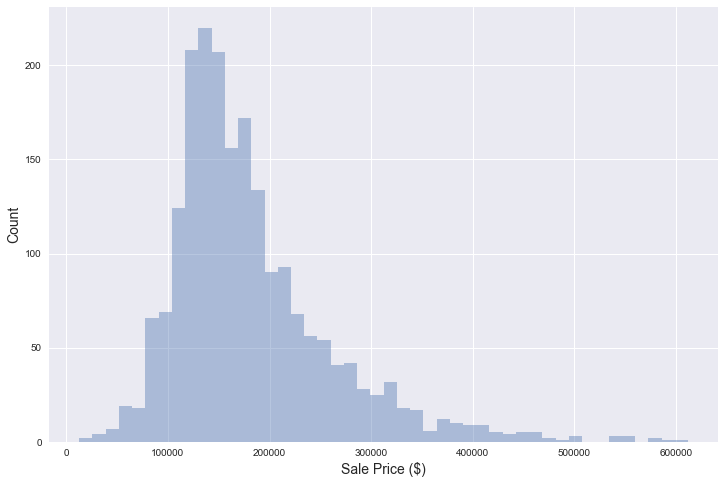

In [13]:
plt.figure(figsize=(12, 8))
sns.distplot(housing.saleprice, kde=False)
plt.xlabel('Sale Price ($)', size=14)
plt.ylabel('Count', size=14);

With this in mind, let's look at the distribution of saleprice after a (log + 1) transform:

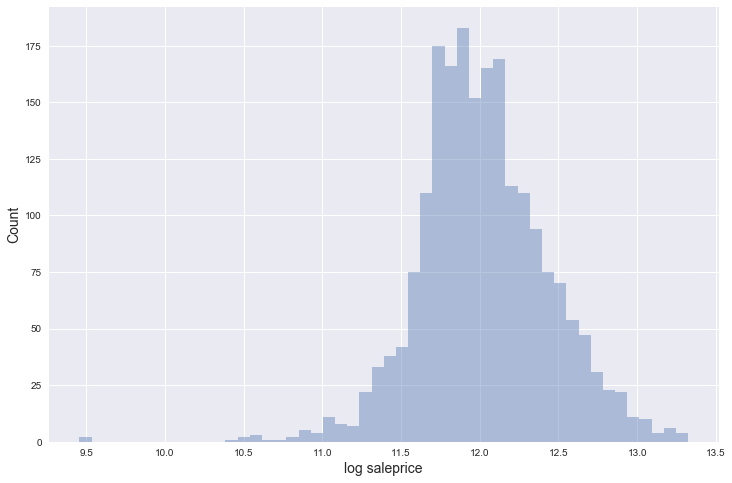

In [12]:
plt.figure(figsize=(12, 8))
sns.distplot(np.log1p(housing.saleprice), kde=False);
plt.xlabel('log saleprice', size=14)
plt.ylabel('Count', size=14);

Since this looks closer to a normal distribution and linear regression works better for approximately normal target variables, let's log transform our sale price:

In [14]:
housing['saleprice'] = np.log1p(housing['saleprice'])

### Correlations between target and features

Let's take a quick look at the correlations between `saleprice` and our features to get a sense of the features that influence price the most:

In [15]:
housing.corr().saleprice.sort_values(ascending=False).head(10)

saleprice         1.000000
overall_qual      0.822775
gr_liv_area       0.687775
garage_cars       0.667781
garage_area       0.650756
year_built        0.624449
total_bsmt_sf     0.621417
year_remod/add    0.599459
1st_flr_sf        0.599087
garage_yr_blt     0.581093
Name: saleprice, dtype: float64

**We see that overall quality, above ground living area, size and capacity of the garage, when the house was built, and the number of bathrooms are strongly correlated with `saleprice`.**

**Next, I plot the relationships between our features and price and do a visual inspection of our data:**

### Plots of Features against Target

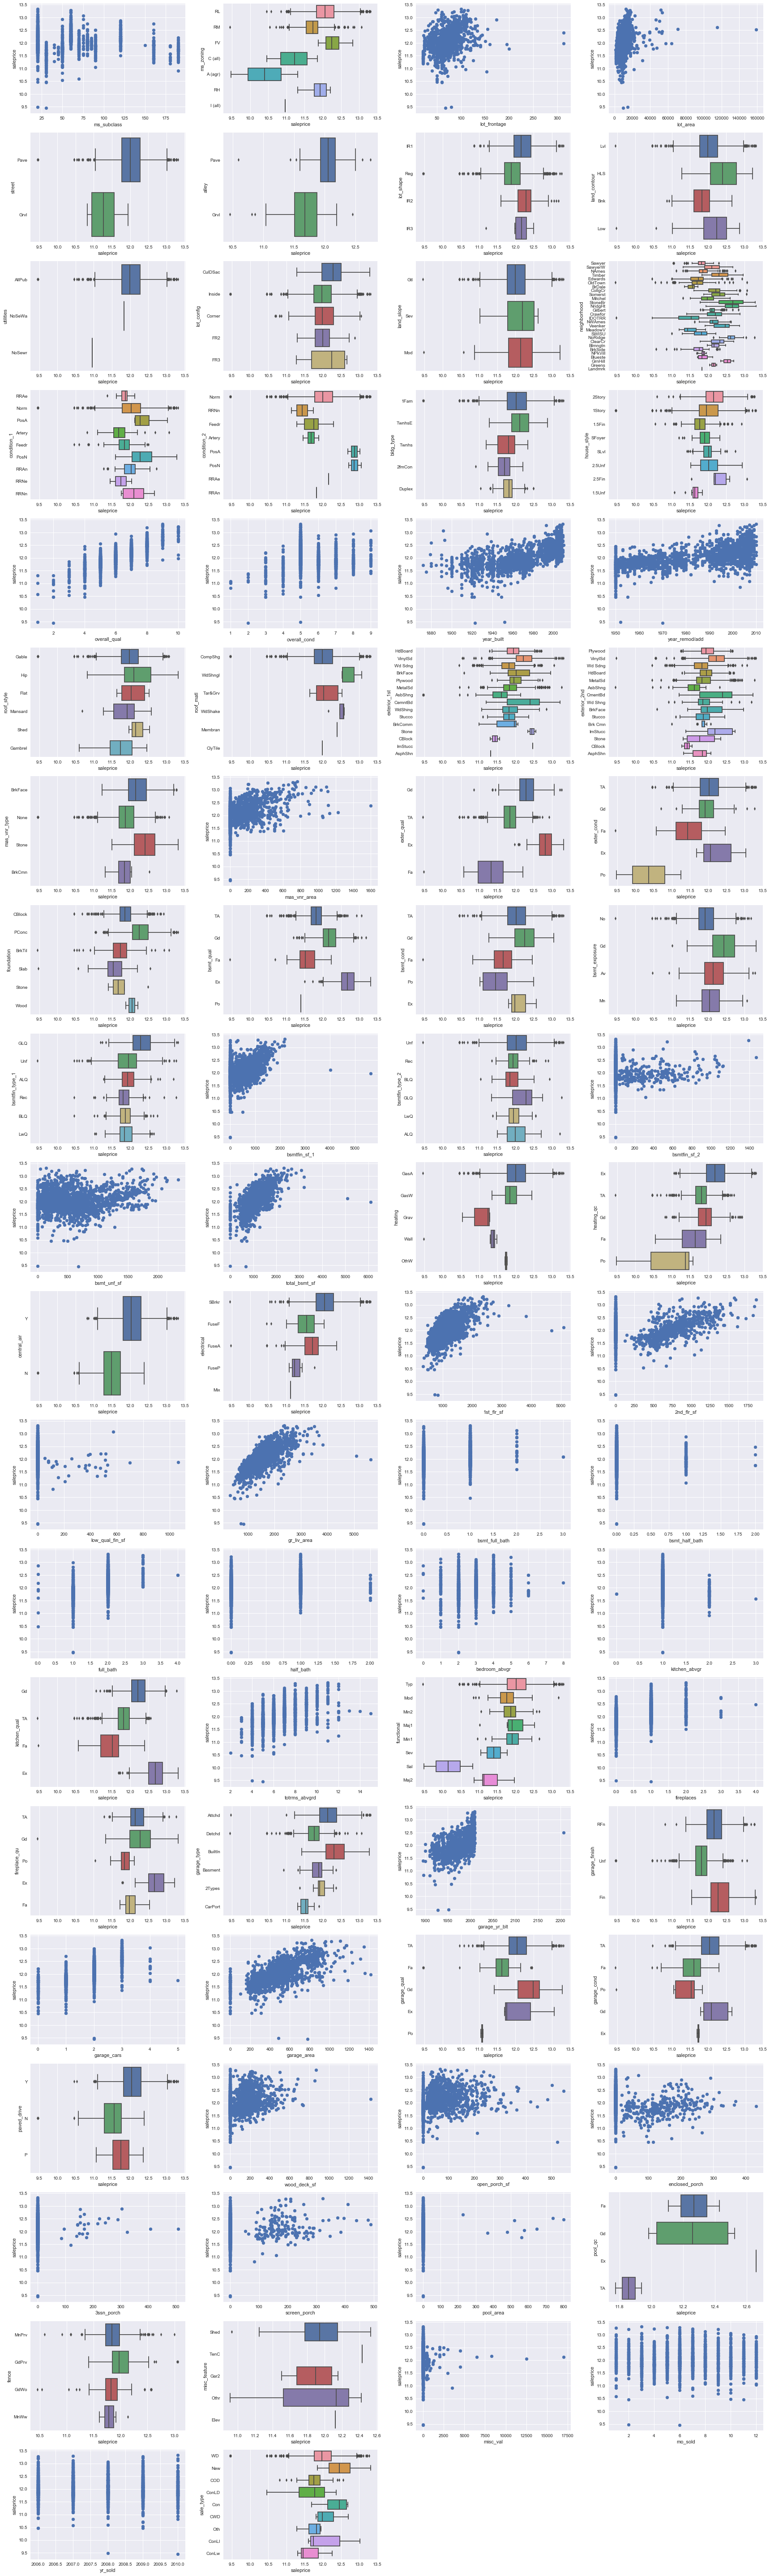

In [16]:
plotting(housing, housing.columns[2:-1], 'saleprice', num_cols=4);

**Based on the output of our plotting function, we confirm our suspicion that some of the numeric variables should be converted to categorical (`ms_subclass` for one). We also observe the presence of outliers in certain features in relation to $log$ saleprice (for example, `lot_frontage` and `lot_area`).**

## Checking for missing values

We can quickly check which columns contain any null values:

In [17]:
housing.columns[housing.isnull().any()]

Index(['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type',
       'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature'],
      dtype='object')

Let's examine these columns more closely:

#### Lot Frontage

Lot frontage was the one of the features with a high correlation with price, yet there were a noticeable number of missing values. There were 330 properties with null values for lot frontage in the training data. Since it is unlikely that properties in Ames have no street access and the data dictionary does not make reference to null values for this feature, I chose to examine this feature more carefully to determine if the null values were a data entry error.

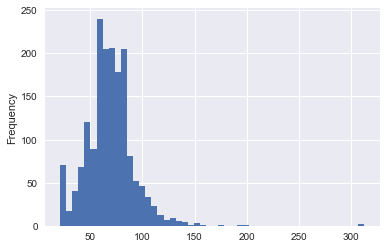

In [18]:
housing['lot_frontage'].plot(kind='hist', bins=50);

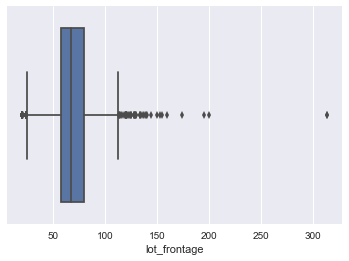

In [19]:
sns.boxplot('lot_frontage', data=housing);

Based on the distribution's significant positive skew as shown in the above plots, I chose to impute the null values with the median lot frontage.

In [20]:
housing['lot_frontage'].replace(np.nan, housing['lot_frontage'].median(), inplace=True)

#### Alley type

Properties with null values for alley did not have access to an alley. However, we see that only 140 homes (6%) had alley access in the data. Let's drop this column.

In [21]:
housing.drop('alley', axis=1, inplace=True)

#### Masonry veneer type and area

The 22 masonry veneer type null values were converted to 'None'. Area for properties with no masonry veneer was imputed as 0 correspondingly.

In [22]:
housing['mas_vnr_type'].replace(np.nan, 'None', inplace=True)

housing['mas_vnr_area'].replace(np.nan, 0, inplace=True)

#### Basement Variables

For the 10 variables quantifying basements, null values signified that the property has no basement. For categorical variables, I changed the value to 'No Basement' instead of null. For continuous variables regarding area (`bsmtfin_sf1`, `bsmtfin_sf2`, `bsmt_unfsf`, `total_bsmt_sf`) and number of rooms (`bsmt_full_bath`, `bsmt_half_bath`) I converted null values to 0.

In [23]:
basement_cats = ['bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2']

housing[basement_cats] = housing[basement_cats].replace({np.nan: 'No basement'})

basement_num = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']

housing[basement_num] = housing[basement_num].replace({np.nan: 0})

#### Garage Variables

Similar to the basement variables, null values for the garage-related variables signified the lack of a garage on the property. I did a similar process to impute *'None'* values for nulls (i.e. 'No garage' for categorical variables and 0 for continuous variables where applicable). I dropped `garage_yr_blt` since it is meaningless if no garage exists.

In [24]:
garage = ['garage_type', 'garage_finish', 'garage_qual', 'garage_cond']

housing[garage] = housing[garage].replace({np.nan: 'No garage'})

garage_num = ['garage_area', 'garage_cars']

housing[garage_num] = housing[garage_num].replace({np.nan: 0})

housing.drop('garage_yr_blt', axis=1, inplace=True)

#### Fireplace Quality, Pool Quality, Fence, Misc Feature

For the remaining categorical variables with missing data, NA signified the lack of the item specified in the category. I inputed the null values as a value of "None".

In [25]:
categories = ['fireplace_qu', 'pool_qc', 'fence', 'misc_feature']

housing[categories] = housing[categories].replace({np.nan: 'None'})

###  Test data processing

Let's handle missing values in our test data in the same way as we did in our training data:

In [26]:
test['lot_frontage'].replace(np.nan, housing['lot_frontage'].median(), inplace=True)

test.drop('alley', axis=1, inplace=True)

test['mas_vnr_type'].replace(np.nan, 'None', inplace=True)

test['mas_vnr_area'].replace(np.nan, 0, inplace=True)

test[basement_cats] = test[basement_cats].replace({np.nan: 'No basement'})

test[basement_num] = test[basement_num].replace({np.nan: 0})

test[garage] = test[garage].replace({np.nan: 'No garage'})

test[garage_num] = test[garage_num].replace({np.nan: 0})

test.drop('garage_yr_blt', axis=1, inplace=True)

test[categories] = test[categories].replace({np.nan: 'None'})

### Checking for data shape

In [27]:
housing.shape, test.shape

((2051, 79), (879, 78))

In [28]:
set(housing.columns)-set(test.columns)

{'saleprice'}

We see that the test data has 1 less feature (the target variable `saleprice`) compared to the training data.

## Exporting 

In [29]:
housing.to_csv('../data/housing_clean.csv', index=False)

In [30]:
test.to_csv('../data/test_clean.csv', index=False)